In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import sys
sys.path.insert(0,'drive/Colab')

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving Asteroid.csv to Asteroid.csv


In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "Asteroid.csv" with length 170117548 bytes


# ***Amaç:*** Bir asteroitin çapını, o asteroit hakkında verilen diğer verilerden elde etmek, bir başka deyişle, hedef log (çap) ile regresyonun denetlenmesi.

**Test sırasında kullanılan ölçüm R2 puanı olacaktır.(metrik)**

# **Adım 1:** Verileri temizleme ve hazırlama

a. Nan çapı olan örnekleri temizledim.

b. Özellikleri yarıdan fazla nan değeri ile düşürdüm.

c. Dataframe'in bir çok nan değeri vardı, bunları karşılık gelen özelliğin ortalama değeri ile değiştirmeyi seçtim.

# **Adım 2:** Verilerin tren testi ile bölünmesi ve test veri çerçevesi kullanılarak normalleştirilmesi (standart).

# **Adım 3:** Farklı regresyon algoritmalarını denemek (Doğrusal Regresyon, Elastik Ağ, Karar Ağacı, Rastgele Orman, XGBoost, SVM, Yapay Sinir Ağı) ve en iyisini seçmek.




# **Modüller:** numpy, pandalar, matplotlib, seaborn, scikit-learn, xgboost, keras.

# **I.Bölüm:** Verilerin ithal edilmesi, keşfedilmesi ve temizlenmesi

In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import seed 
seed(42)
df = pd.read_csv('Asteroid.csv',nrows=30000)
print(df)

                           full_name         a         e  ...  neo  pha      moid
0                            1 Ceres  2.769165  0.076009  ...    N    N  1.594780
1                           2 Pallas  2.772466  0.230337  ...    N    N  1.233240
2                             3 Juno  2.669150  0.256942  ...    N    N  1.034540
3                            4 Vesta  2.361418  0.088721  ...    N    N  1.139480
4                          5 Astraea  2.574249  0.191095  ...    N    N  1.095890
...                              ...       ...       ...  ...  ...  ...       ...
29995              29996 (2000 AQ97)  1.921198  0.053971  ...    N    N  0.869993
29996             29997 (2000 AE127)  2.334437  0.227032  ...    N    N  0.812942
29997             29998 (2000 AG137)  2.138893  0.117819  ...    N    N  0.874022
29998             29999 (2000 AT137)  2.637737  0.139574  ...    N    N  1.283730
29999   30000 Camenzind (2000 AB138)  2.267328  0.079972  ...    N    N  1.080930

[30000 rows x 2

In [ ]:
df.head()

,full_name,a,e,G,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,1 Ceres,2.769165,0.076009,0.12,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822,0,1002,3.34,939.4,964.4 x 964.2 x 891.8,0.0900,9.074170,62.6284,0.713,0.426,NaN,C,G,N,N,1.59478
1,2 Pallas,2.772466,0.230337,0.11,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318,0,8490,4.13,545,582x556x500,0.1010,7.813200,14.3000,0.635,0.284,NaN,B,B,N,N,1.23324
2,3 Juno,2.669150,0.256942,0.32,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684,0,7104,5.33,246.596,NaN,0.2140,7.210000,NaN,0.824,0.433,NaN,Sk,S,N,N,1.03454
3,4 Vesta,2.361418,0.088721,0.32,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288,0,9325,3.20,525.4,572.6 x 557.2 x 446.4,0.4228,5.342128,17.8000,0.782,0.492,NaN,V,V,N,N,1.13948
4,5 Astraea,2.574249,0.191095,NaN,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431,0,2861,6.85,106.699,NaN,0.2740,16.806000,NaN,0.826,0.411,NaN,S,S,N,N,1.09589


**NaN değerleri kontrolü**

In [ ]:
for column in df.columns:
    print(column, df[column].isna().sum()/df.shape[0]) #NAN değerlerinin kesirini döndürür.

full_name 0.0
a 0.0
e 0.0
G 0.9961666666666666
i 0.0
om 0.0
w 0.0
q 0.0
ad 0.0
per_y 0.0
data_arc 0.0
condition_code 0.0
n_obs_used 0.0
H 0.0
diameter 0.2462
extent 0.9995
albedo 0.2468
rot_per 0.7246333333333334
GM 0.9996
BV 0.9660666666666666
UB 0.9674666666666667
IR 1.0
spec_B 0.9515333333333333
spec_T 0.9674666666666667
neo 0.0
pha 0.0
moid 0.0


**Bir sonraki şey, ne tür verilerle uğraştığımızı anlamak.**

In [ ]:
for column in df.columns:
    print(column, df[column].unique()[:5])

full_name ['     1 Ceres' '     2 Pallas' '     3 Juno' '     4 Vesta'
 '     5 Astraea']
a [2.76916515 2.77246592 2.66914952 2.3614179  2.57424892]
e [0.07600903 0.23033682 0.25694232 0.08872146 0.19109452]
G [0.12 0.11 0.32  nan 0.24]
i [10.59406704 34.83623442 12.98891913  7.14177081  5.36698794]
om [ 80.30553157 173.08006275 169.85275981 103.81080443 141.57660421]
w [ 73.59769412 310.04885743 248.13862618 150.72854129 358.68760779]
q [2.5586836  2.13386493 1.98333205 2.15190945 2.08232406]
ad [2.97964671 3.41106691 3.35496699 2.57092634 3.06617378]
per_y [4.6082018  4.61644353 4.36081392 3.62883714 4.13032295]
data_arc [ 8822 72318 72684 24288 63431]
condition_code [0 2 1 4 3]
n_obs_used [1002 8490 7104 9325 2861]
H [3.34 4.13 5.33 3.2  6.85]
diameter ['939.4' '545' '246.596' '525.4' '106.699']
extent ['964.4 x 964.2 x 891.8' '582x556x500' nan '572.6 x 557.2 x 446.4'
 '279 x 232 x 189']
albedo [0.09   0.101  0.214  0.4228 0.274 ]
rot_per [ 9.07417     7.8132      7.21        5.3421

### * 'çap' özelliğini string türünde sayısal veriye dönüştüreceğim. Bu bazı çaplar için hatalar verdi, çünkü bunlar bozuktu, bu yüzden bozuk çapları nan olarak ayarlamak için "errors = 'coerce'" argümanını ekledim. 

* İşe yaramayacağını düşündüğüm özellikleri drop ediyorum. Mesela Astroid isimleri gibi.




In [ ]:
df['diameter']=pd.to_numeric(df['diameter'],errors='coerce') #sayısala dönüştürme, hataları NaN olarak ayarlama
dropindexes = df['diameter'][df['diameter'].isnull()].index #Çap özelliğinde değeri NaN olanları drop ediyorum
dropped_df = df.loc[dropindexes] #drop ettiğim satırları ileride kullanma ihtimalime karşı kaydediyorum.
df = df.drop(dropindexes, axis=0) # Verimin son hali


In [ ]:
fazlaNa = df.columns[df.isna().sum()/df.shape[0] > 0.5]
df = df.drop(fazlaNa,axis=1)
df = df.drop(['condition_code','full_name'],axis=1)
df = df.drop(['neo','pha'],axis=1) #Gereksiz özellikleri drop ediyorum.

In [ ]:

df.head()

,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,diameter,albedo,moid
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822,1002,3.34,939.400,0.0900,1.59478
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318,8490,4.13,545.000,0.1010,1.23324
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684,7104,5.33,246.596,0.2140,1.03454
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288,9325,3.20,525.400,0.4228,1.13948
4,2.574249,0.191095,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431,2861,6.85,106.699,0.2740,1.09589


In [ ]:
df = df.fillna(df.mean()) #eksikliklik olan sütunları ,değerlerin ortalaması ile doldurdum.


#df.mean #
Metot panda serisi bir nesneye uygulanırsa, metot dataframe'deki tüm gözlemlerin ortalama değeri olan bir skaler değeri döndürür. Yöntem bir pandaların veri çerçevesi nesnesine uygulanırsa, yöntem belirtilen eksen üzerindeki değerlerin ortalamasını içeren bir panda serisi nesnesini döndürür.

In [ ]:
df.head()

,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,diameter,albedo,moid
0,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822,1002,3.34,939.400,0.0900,1.59478
1,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318,8490,4.13,545.000,0.1010,1.23324
2,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684,7104,5.33,246.596,0.2140,1.03454
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288,9325,3.20,525.400,0.4228,1.13948
4,2.574249,0.191095,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431,2861,6.85,106.699,0.2740,1.09589


In [ ]:
df.isna().values.any() #Kalan NaN değeri var mı kontrol etmek için

False

Nasa'nın kendi Asteroid Tahmincisi web sitesi H değerini ve log kullanıyor

In [ ]:
df = df.drop(['albedo','H'],axis = 1)

In [ ]:
df['diameter']= df['diameter'].apply(np.log)
for column in df.columns.drop(['diameter']):
    df['log('+column+')']=df[column].apply(np.log)
df = df.dropna(axis=1)

In [ ]:
#NA / null değerleri hariç sütunların ikili korelasyonunu hesaplayın.

df.corr()['diameter'].abs().sort_values(ascending=False)

diameter           1.000000
log(per_y)         0.622497
log(a)             0.622497
log(ad)            0.605441
data_arc           0.583459
log(q)             0.533683
n_obs_used         0.526710
log(data_arc)      0.522696
log(moid)          0.504905
a                  0.500553
log(n_obs_used)    0.483892
moid               0.477567
ad                 0.476470
q                  0.473422
per_y              0.316803
i                  0.255413
log(i)             0.211454
log(e)             0.059763
e                  0.055441
w                  0.004292
log(w)             0.004283
log(om)            0.002104
om                 0.001198
Name: diameter, dtype: float64

# **II. Bölüm:** Veri setini eğitim ve test setlerine bölmek ve regresyonlarımız için normalleştirme

In [ ]:
from sklearn.model_selection import train_test_split
predictors = df.drop('diameter',axis=1) 
target = df['diameter']
X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=42) # %20 test seti %80 eğitim seti yapıyorum.

In [ ]:
X_train.head()

,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,moid,log(a),log(e),log(i),log(om),log(w),log(q),log(ad),log(per_y),log(data_arc),log(n_obs_used),log(moid)
16613,3.062184,0.042087,3.550925,43.434362,136.814822,2.933305,3.191062,5.358646,9542,1626,1.937100,1.119128,-3.168016,1.267208,3.771251,4.918628,1.076130,1.160354,1.678711,9.163458,7.393878,0.661192
16014,3.142085,0.135951,1.948769,73.770416,186.571290,2.714915,3.569255,5.569741,9884,1425,1.699210,1.144886,-1.995460,0.667198,4.300958,5.228813,0.998761,1.272357,1.717349,9.198673,7.261927,0.530163
25744,3.020886,0.033215,11.425086,205.866217,160.642165,2.920547,3.121225,5.250608,11674,1640,1.922040,1.105550,-3.404752,2.435811,5.327227,5.079179,1.071771,1.138225,1.658344,9.365119,7.402452,0.653387
17648,2.611925,0.178348,15.504828,215.288742,68.848243,2.146095,3.077756,4.221330,10105,1109,1.184260,0.960088,-1.724021,2.741151,5.371980,4.231905,0.763650,1.124201,1.440150,9.220786,7.011214,0.169118
4612,2.663696,0.302920,6.652923,144.965850,255.255668,1.856808,3.470584,4.347456,32853,2617,0.877342,0.979715,-1.194285,1.895056,4.976498,5.542266,0.618859,1.244323,1.469591,10.399798,7.869784,-0.130858


**Normalizasyon sebebi ; Bir özelliğin,diğerlerinden daha büyük sıralamasına sahip bir varyansı varsa , nesnel işleme hükmedebilir ve tahmin edicinin beklendiği gibi diğer özelliklerden öğrenememesini sağlayabilir.**

In [ ]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler().fit(X_train)

def scaler(X):
    x_norm_arr= std_scaler.fit_transform(X) #fit_transform diyerek normalleştiriyorum.
    return pd.DataFrame(x_norm_arr, columns=X.columns, index = X.index)

X_train_norm = scaler(X_train)
X_test_norm = scaler(X_test)

def inverse_scaler(X):
    x_norm_arr= std_scaler.inverse_transform(X)
    return pd.DataFrame(x_norm_arr, columns=X.columns, index = X.index)

# **III.Bölüm :** Farklı regresyonlar ile R2 puanlarını incelemek.

**r2 score**:  Belirleme katsayısı olarak bilinir. Regresyon hattına sığdırılan verinin ne kadar yakın olduğuna dair istatistiksel bir ölçüdür.


In [ ]:
from sklearn.metrics import r2_score
import seaborn as sns

def plot(prediction):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7)) 
    sns.distplot(Y_test.values,label='test değerleri', ax=ax1)
    sns.distplot(prediction ,label='tahminler', ax=ax1)
    ax1.set_xlabel('Dağılım')
    ax2.scatter(Y_test,prediction, c='orange',label='tahminler')
    ax2.plot(Y_test,Y_test,c='blue',label='y=x')
    ax2.set_xlabel('test değerleri')
    ax2.set_ylabel('tahmini $\log(yarıçap)$')
    ax1.legend()
    ax2.legend()
    ax2.axis('scaled') 
def score(prediction): #score fonksiyonu
    score = r2_score(prediction,Y_test)
    return score
def announce(score): #score sonucunu gösterme fonksiyonu
    print('Bu regresyon kullanılarak elde edilen R ^ 2 puanı:', round(score,3))
algorithms = []
scores = []

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Linear Regression**

İlk olarak, regresyon, bağımsız değişken (ler) in bağımlı bir değişken üzerindeki etkisinin gücünü belirlemek için kullanılabilir. Tipik sorular, doz ve etki, satış ve pazarlama harcamaları veya yaş ve gelir arasındaki ilişkinin gücüdür.

İkincisi, değişikliklerin etkilerini veya etkisini tahmin etmek için kullanılabilir. Yani, regresyon analizi, bir veya daha fazla bağımsız değişkende bir değişiklikle bağımlı değişkenin ne kadar değiştiğini anlamamıza yardımcı olur. Tipik bir soru, “pazarlama için harcanan her 1000 dolar için ne kadar ek satış geliri elde edeceğim?”.

Üçüncüsü, regresyon analizi eğilimleri ve gelecekteki değerleri öngörmektedir. Regresyon analizi, nokta tahminlerini almak için kullanılabilir. Tipik bir soru, “altın fiyatı 6 ayda ne olacak?” Şeklindedir.

y=b0+b1*x
b0=constant(bias) ,b0 line'ın y eksenini kestiği nokta
b1=coeff(katsayım) ,b1'de line'ın eğimi

In [ ]:
# Modelin oluşturulması
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Modelimi fit ediyorum.
lr.fit(X_train,Y_train)

# Tahminleme(predict)
Y_pred_lr = lr.predict(X_test)
print(Y_pred_lr) #tahmin edilen değerleri yazdırıyorum.

#Skor
score_lr = score(Y_pred_lr)
announce(score_lr) #announce fonksiyonunu yukarda yazmıştık. 

algorithms = []
scores = []
algorithms.append('LR') # sonucun ismini algoritmalar listeme yüklüyorum.
scores.append(score_lr) # sonucun değerini skorlar listeme ekliyorum.


[2.3138739  2.08334094 2.18674327 ... 1.54204931 1.58684028 1.50123234]
Bu regresyon kullanılarak elde edilen R ^ 2 puanı: 0.763


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(mean_squared_error(Y_test, Y_pred_lr))



0.3532609798762887

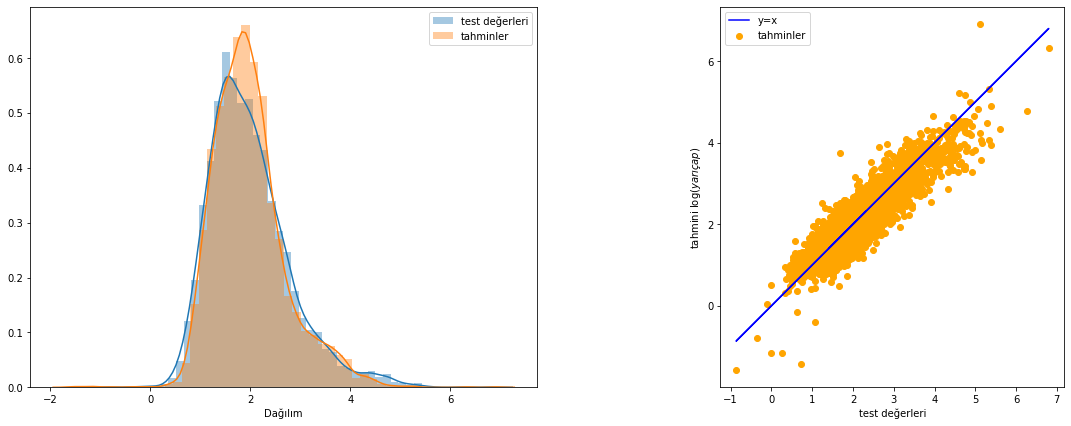

In [ ]:
plot(Y_pred_lr) #grafiğe döküyorum

# **k-Nearest Neighbours regression**

K'ye en yakın komşular, mevcut tüm vakaları depolayan ve benzerlik ölçüsüne (örneğin, mesafe işlevleri) dayanarak sayısal hedefi öngören basit bir algoritmadır. KNN, 1970'lerin başında parametrik olmayan bir teknik olarak, istatistiksel tahmin ve örüntü tanıma işlemlerinde kullanılmıştır.

1)K değerini seç
2)K en yakın data noktaları bul
3)K en yakın komşu arasında hangi classtan kaç tane var hesapla
4)Test ettiğimiz point yada data hangi classa ait tespit et.

!!! KNN' de normalize etmek önemli çünkü mesela y değerleri çok küçük olursa x değerlerine göre ;bir şey değişmemiş oluyor. O yüzden normalize edeceğiz tüm değerleri.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


neigh = KNeighborsRegressor(n_neighbors=3)

# Modelimi fit ediyorum yani eğitiyorum.
neigh.fit(X_train_norm,Y_train)

# Tahminleme
Y_pred_neigh = neigh.predict(X_test_norm)
print(Y_pred_neigh)

#Skor
score_neigh=score(Y_pred_neigh)
announce(score_neigh)

algorithms.append('k-NN')
scores.append(score_neigh)

[1.85470898 1.67146784 2.5821907  ... 1.32838207 1.09569109 1.59675968]
Bu regresyon kullanılarak elde edilen R ^ 2 puanı: 0.744


In [ ]:
sqrt(mean_squared_error(Y_test, Y_pred_neigh))

0.3673281819837405

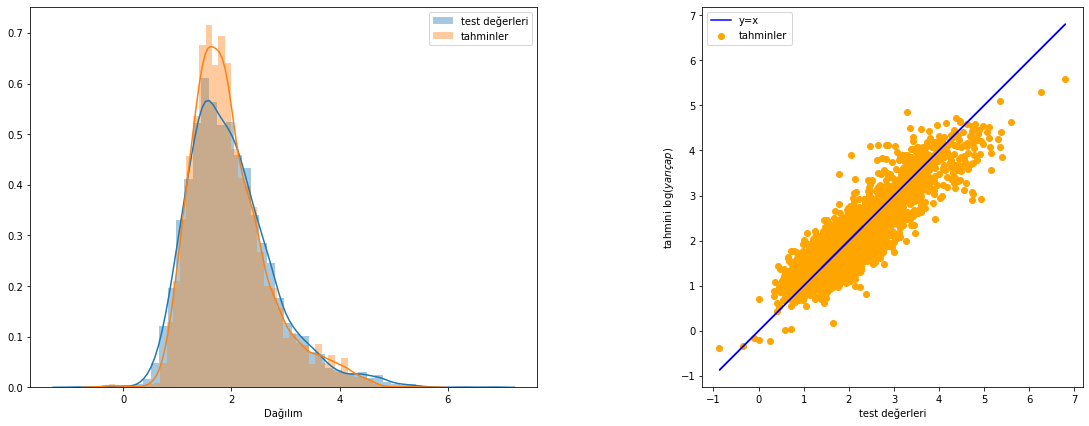

In [ ]:
plot(Y_pred_neigh)

# **Decision Tree regression**

Karar ağacı, bir ağaç yapısı şeklinde regresyon veya sınıflandırma modelleri oluşturur. Bir veri kümesini daha küçük ve daha küçük alt gruplara ayırırken, aynı zamanda ilişkili bir karar ağacı kademeli olarak geliştirilir. Sonuç, karar düğümleri ve yaprak düğümleri olan bir ağaçtır.

In [ ]:
from sklearn import tree
decTree = tree.DecisionTreeRegressor()

#Eğitim
decTree = decTree.fit(X_train_norm,Y_train)

#Tahminleme
Y_pred_tree = decTree.predict(X_test_norm)

#Skor
score_tree = score(Y_pred_tree)
announce(score_tree)

algorithms.append('DTree')
scores.append(score_tree)

Bu regresyon kullanılarak elde edilen R ^ 2 puanı: 0.585


In [ ]:
sqrt(mean_squared_error(Y_test, Y_pred_tree))

0.5025647259366783

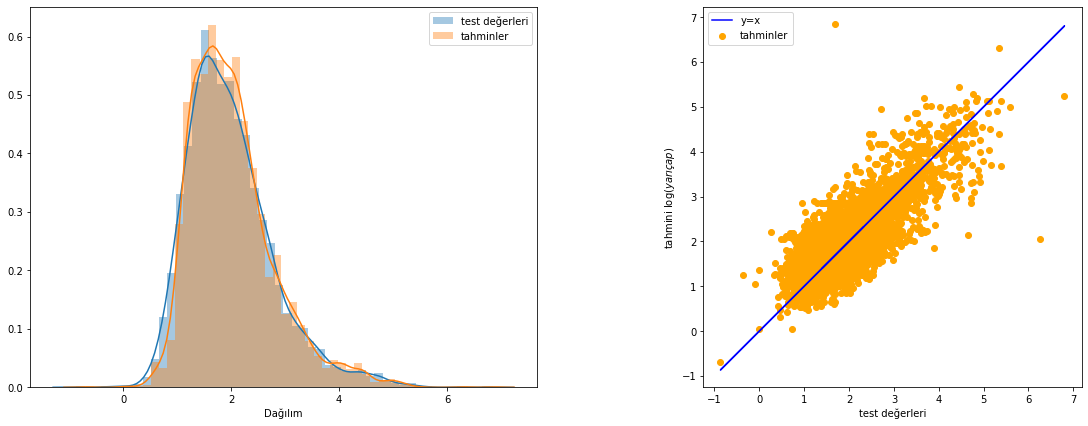

In [ ]:
plot(Y_pred_tree)

# **Random Forest regression**

Topluluklar, performansı iyileştirmek için kullanılan bir böl ve ele geçir yaklaşımıdır. Topluluk yöntemlerinin arkasındaki ana ilke, bir grup “zayıf öğrenci” nin “güçlü bir öğrenci” oluşturmak için bir araya gelmesidir. Aşağıdaki şekil (buradan alınmıştır) bir örnek teşkil etmektedir. Her bir sınıflandırıcı, bireysel olarak “zayıf bir öğrenci” iken, bir araya getirilen tüm sınıflandırıcılar “güçlü bir öğrenicidir”.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=32, n_estimators=50)

 
forest.fit(X_train_norm,np.ravel(Y_train))


Y_pred_forest = forest.predict(X_test_norm)


score_forest = score(Y_pred_forest)
announce(score_forest)

algorithms.append('RForest')
scores.append(score_forest)

Bu regresyon kullanılarak elde edilen R ^ 2 puanı: 0.756


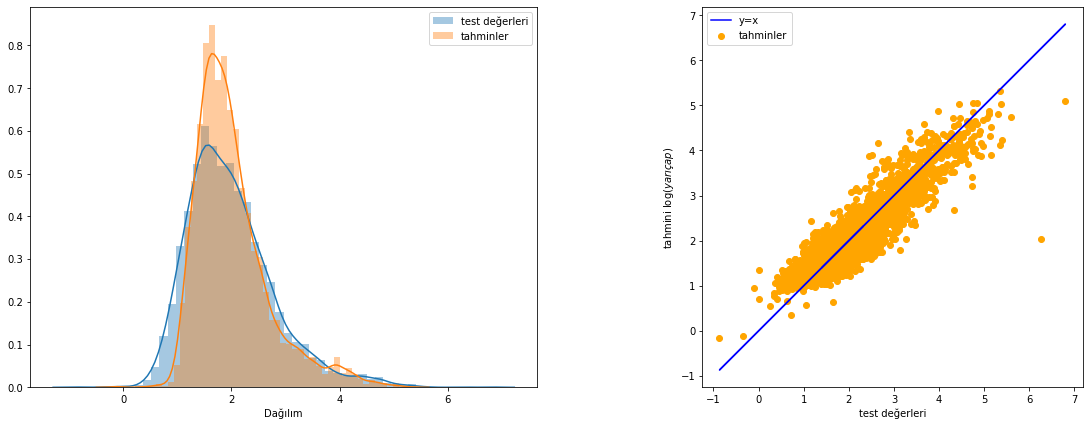

In [ ]:
plot(Y_pred_forest)

Support Vector Machine regression

“Support Vector Machine” (SVM) hem sınıflandırma hem de regresyon zorlukları için kullanılabilecek denetimli bir makine öğrenme algoritmasıdır. Ancak, çoğunlukla sınıflandırma problemlerinde kullanılır. Bu algoritmada, her bir veri öğesini n-boyutlu uzayda (n'nin sahip olduğu özelliklerin sayısıdır) bir nokta olarak çiziyoruz, her özelliğin değeri belirli bir koordinatın değeri. Ardından, iki sınıfı çok iyi ayıran hiper düzlemi bularak sınıflandırma yapıyoruz.

In [ ]:
from sklearn import svm
svmreg = svm.SVR()


svmreg.fit(X_train_norm,np.ravel(Y_train))


Y_pred_svm = svmreg.predict(X_test_norm)


score_svm = score(Y_pred_svm)
announce(score_svm)

algorithms.append('SVM')
scores.append(score_svm)

Bu regresyon kullanılarak elde edilen R ^ 2 puanı: 0.761


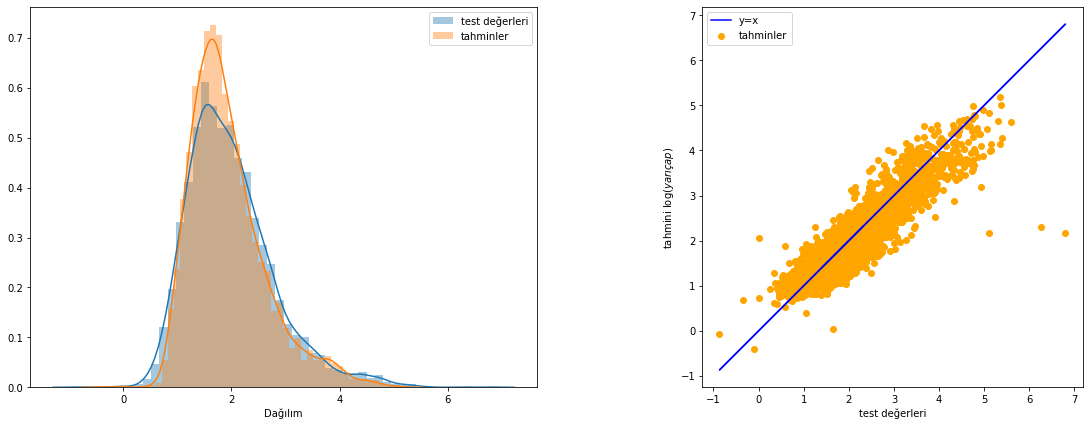

In [ ]:
plot(Y_pred_svm)

In [ ]:
!pip install -q keras
import keras

Using TensorFlow backend.


**Neural Network regression**

In [ ]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

Adam(lr=0.05) #learning rate öğrenme hızıdır.
model = Sequential() # nodeli oluşturmak için bir giriştir bu. (İntialize)
# Dense,layerlarımızı inşa etmek(build)için kullanılır. 
#24 Çıkış düğümü
model.add(Dense(24,activation='tanh',input_dim=X_train_norm.shape[1])) #tanh = relu (aktivasyon fonksiyonu) ,
model.add(Dense(12,activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam') 


#Modelimi eğitiyorum
model.fit(X_train_norm,Y_train,epochs=100,batch_size=256,verbose=False)

#Tahminleme

Y_pred_nn = model.predict(X_test_norm)

#Skor
score_nn = score(Y_pred_nn)
announce(score_nn)

algorithms.append('NNet')
scores.append(score_nn)

In [ ]:
plot(Y_pred_nn)

# **XGBoost regression**

Boosting, bir topluluk prensibi üzerinde çalışan sıralı bir tekniktir. Bir dizi zayıf öğreniciyi birleştirir ve gelişmiş tahmin doğruluğu sunar. Herhangi bir anda t, önceki anlık t-1'in sonuçlarına göre model sonuçları tartılır. Doğru öngörülen sonuçlara daha düşük ağırlık verilir ve yanlış sınıflandırılanlara daha yüksek ağırlık verilir. Zayıf bir öğrencinin rastgele tahminden biraz daha iyi olduğunu unutmayın. Örneğin, tahminleri% 50'den biraz daha iyi olan bir karar ağacı. 

In [ ]:
import xgboost as xgb 
xgReg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, 
                         learning_rate = 0.08 ,
                max_depth = 4, n_estimators = 500)

xgReg.fit(X_train_norm,Y_train)


Y_pred_xgb = xgReg.predict(X_test_norm)


score_xgb = score(Y_pred_xgb)
announce(score_xgb)

algorithms.append('XGB')
scores.append(score_xgb)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Bu regresyon kullanılarak elde edilen R ^ 2 puanı: 0.845


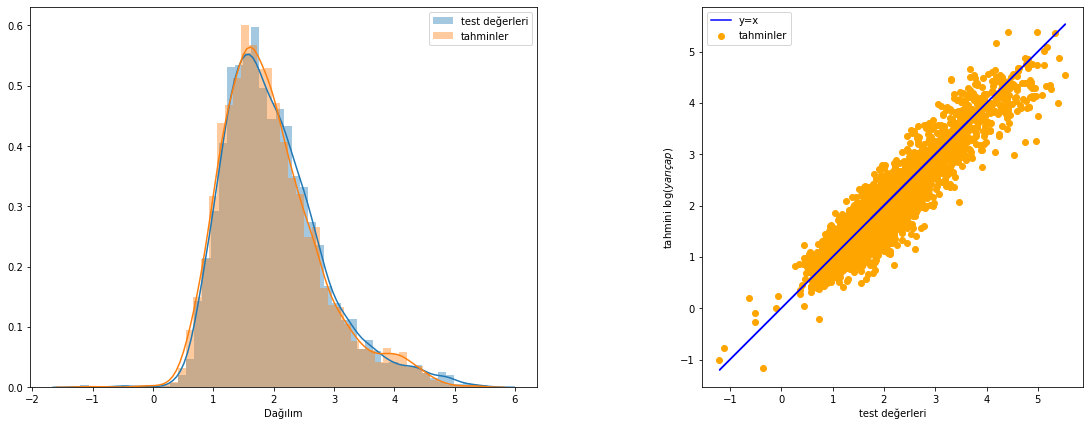

In [ ]:
plot(Y_pred_xgb)

# **ALGORİTMALARIN KARŞILAŞTIRILMASI**

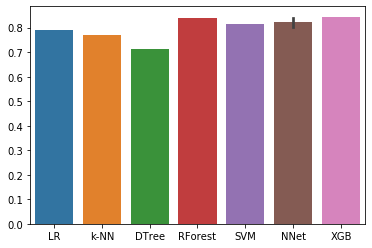

In [ ]:
sns.barplot(algorithms,scores)